In [1]:
% matplotlib inline

from __future__ import division

import glob
import numpy as np
from collections import namedtuple
from fractions import Fraction

import colour
from colour.plotting import *

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_DDFAPD)
from colour_hdri.exif import get_exif_data
from colour_hdri.merge import merge_to_hdri
from colour_hdri.weighting_functions import (
    hat_function,
    normal_distribution_function,
    weighting_function_Debevec1997)


DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Cube_002/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

ExifData = namedtuple('ExifData', ('aperture', 'shutter_speed', 'iso'))

Image = namedtuple('Image', ('path', 'data', 'exif_data'))


def process1(dng_files):
    print('Reading Images...')
    images = []
    for dng_file in dng_files:
        exif_data = get_exif_data(dng_file)
        aperture = float(exif_data['EXIF']['Aperture Value'][0])
        shutter_speed = float(Fraction(
            exif_data['EXIF']['Shutter Speed Value'][0]))
        iso = float(exif_data['EXIF']['ISO'][0])

        images.append(Image(dng_file,
                            colour.read_image(dng_file.replace('dng', 'tiff')),
                            ExifData(aperture, shutter_speed, iso)))
        
    return images

IMAGES = process1(dng_files = glob.glob('{0}/*.dng'.format(DIRECTORY)))

Reading Images...


In [2]:
def process2(images, black_level=None, white_level=None):
    
    if black_level is None:
        black_level = 0

    if white_level is None:
        white_level = 0
        for image in images:
            white_level = max(white_level, np.max(image.data))

    # TODO: Need a mutable data structure here.
    scaled_images = []
    for image in images:
        data = image.data - black_level
        data *= 1 / white_level

        scaled_images.append(Image(image.path, data, image.exif_data))
    
    return scaled_images
        
IMAGES = process2(IMAGES)

Merging Images...


/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour_hdri/merge.py:30: RuntimeWarning: invalid value encountered in true_divide
  image_c /= weight_c


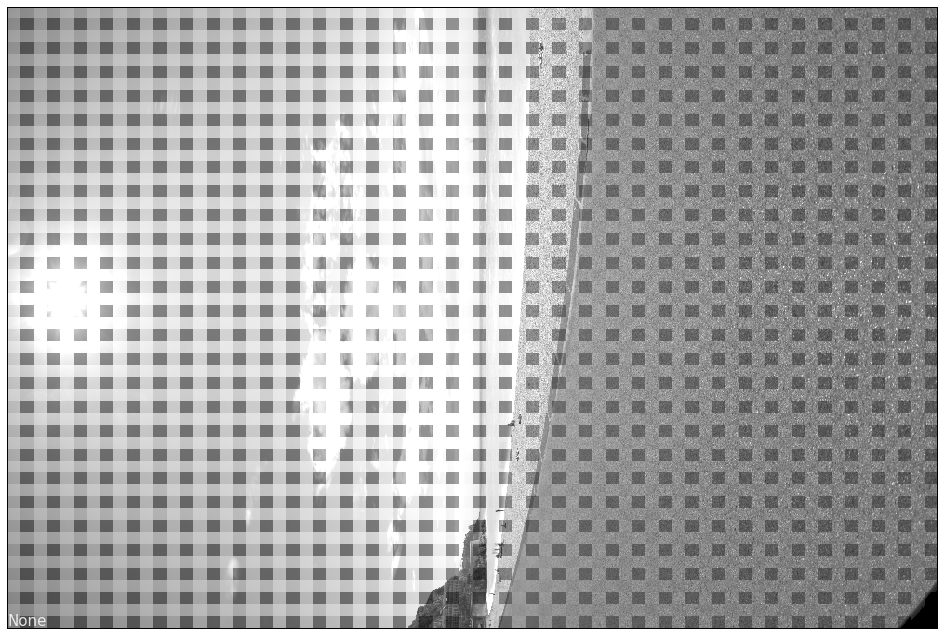

In [3]:
def custom_weight_function(a):
    a = np.asarray(a)

    return np.where(a < 0.5,
                   weighting_function_Debevec1997(a),
                   1)


def process3(images):
    print('Merging Images...')
    image = merge_to_hdri(images, custom_weight_function)

    colour.write_image(image, '{0}/CFA_Merge.exr'.format(DIRECTORY))

    image_plot(OECF(colour.tstack((image, image, image))))
    
    return image

IMAGE = process3(IMAGES)

Debayering Image...


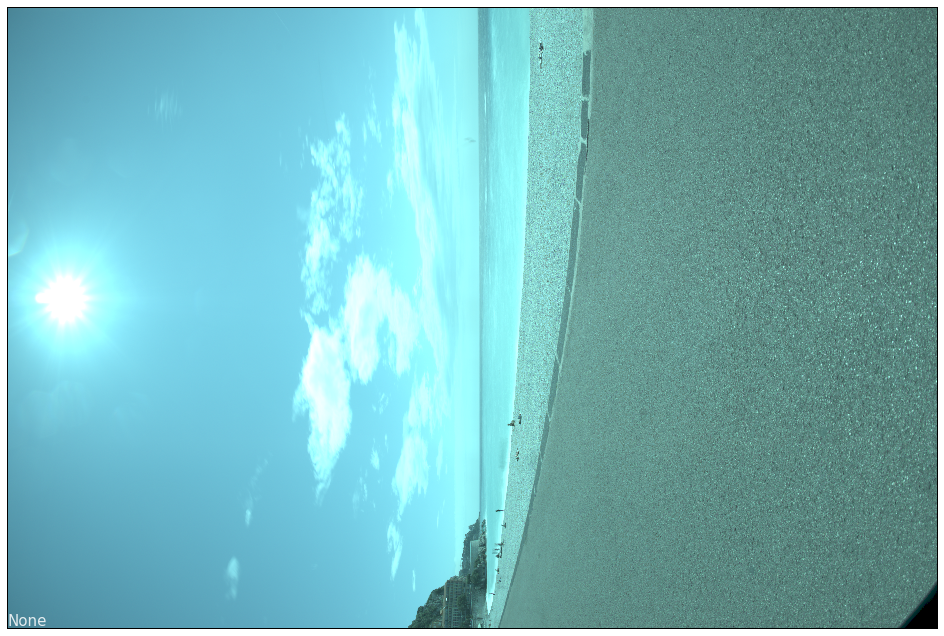

array([[[ 0.14034173,  0.10499588,  0.06948982],
        [ 0.09434798,  0.26496824,  0.13897963],
        [ 0.0951348 ,  0.15966776,  0.13920688],
        ..., 
        [ 0.08459249,  0.16609967,  0.06037103],
        [ 0.08678249,  0.10590703,  0.064161  ],
        [ 0.04339125,  0.22899313,  0.10192644]],

       [[ 0.09184574,  0.26001116,  0.13897963],
        [ 0.06121448,  0.2127619 ,  0.27795926],
        [ 0.06119846,  0.21542147,  0.27841377],
        ..., 
        [ 0.05803637,  0.13549123,  0.12074207],
        [ 0.0591826 ,  0.13808628,  0.12832199],
        [ 0.0295913 ,  0.11180775,  0.20385288]],

       [[ 0.09013034,  0.15882477,  0.13912278],
        [ 0.0595303 ,  0.2156426 ,  0.27824557],
        [ 0.05897372,  0.2141762 ,  0.27923545],
        ..., 
        [ 0.05967775,  0.1343741 ,  0.12873245],
        [ 0.0605102 ,  0.1457938 ,  0.134874  ],
        [ 0.0302551 ,  0.19560326,  0.21152334]],

       ..., 
       [[ 0.09019925,  0.25233815,  0.13306687],
        

In [4]:
def process4(image):
    print('Debayering Image...')
    image = demosaicing_CFA_Bayer_bilinear(image)

    colour.write_image(image, '{0}/Merge.exr'.format(DIRECTORY))

    image_plot(OECF(image))
    
    return image

process4(IMAGE)

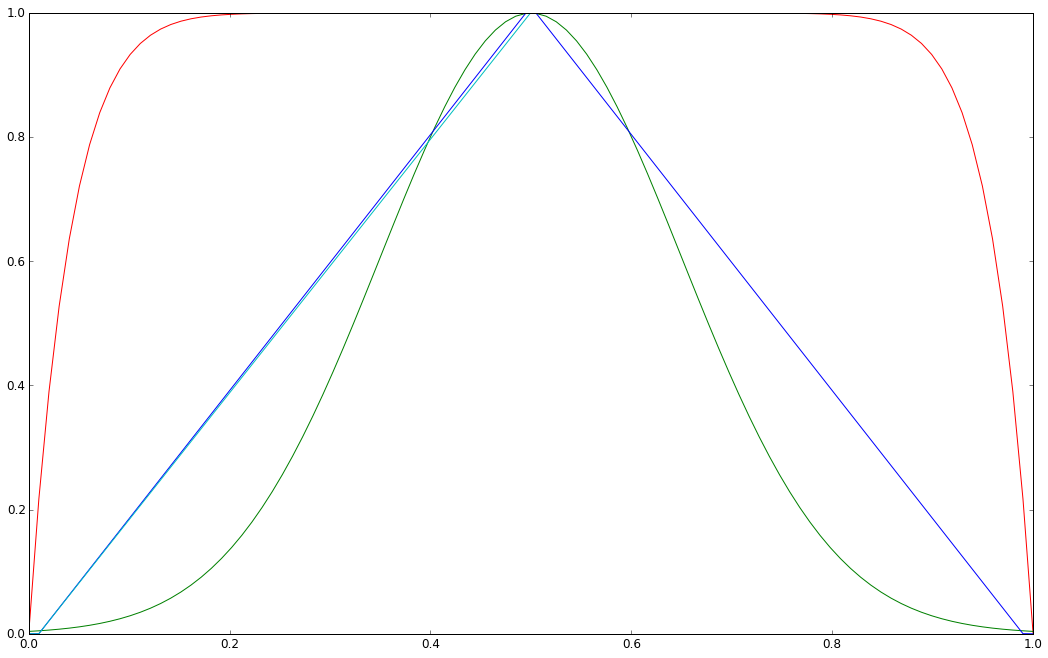

In [5]:
import pylab

pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)), label='Hat')
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)), label='Normal')
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec1997(np.linspace(0, 1, 100)), label='Debevec (1997)')
pylab.plot(np.linspace(0, 1, 1000), custom_weight_function(np.linspace(0, 1, 1000)), label='Custom')

pylab.show()